In [114]:
import random
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import torch
import torch.nn as nn
import time
import matplotlib.pyplot as plt

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

from sb3_contrib import MaskablePPO
from sb3_contrib.common.maskable.evaluation import evaluate_policy
from sb3_contrib.common.maskable.utils import get_action_masks
from sb3_contrib.common.wrappers import ActionMasker

import sys
sys.path.append("Stochasticmuzero")
from muzero_model import Muzero
sys.path.pop()
# from sb3_contrib.common.maskable.wrappers import VecActionMasker 
# from sb3_contrib.common.maskable.vec_env import MaskableEnv
# from stable_baselines3.common.vec_env import DummyVecEnv

'Stochasticmuzero'

# 2x2

In [ ]:
class TwentyFortyEight2b2Env(gym.Env):
    metadata = {"render_modes": ["human"], "render_fps": 4}

    def __init__(self, render_mode='human', generous=0):
        super().__init__()
        self.render_mode = render_mode
        self.observation_space = spaces.Box(0, 10, shape=(2, 2), dtype=np.int8)
        self.action_space = spaces.Discrete(4)
        self.grid = None
        self.generous = generous

    def reset(self, seed=None, options=None):
        # this lets gymnasium/SB3 seed properly
        super().reset(seed=seed)
        self.grid = np.zeros((2, 2), dtype=np.int8)
        self._add_tile()
        self._add_tile()
        return self.grid.copy(), {"action_mask": self.valid_action_mask()}

    def step(self, action):
        assert self.action_space.contains(action), f"{action} invalid"
        terminated = not self._can_move()
        before = self.grid.copy()
        reward = self._move_and_merge(action)
        if not np.array_equal(before, self.grid):
            self._add_tile()
        elif not self.generous:
            terminated = True
        return self.grid.copy(), reward, terminated, False, {"action_mask": self.valid_action_mask()}

    def render(self):
        grd = (np.where(self.grid != 0, 2**self.grid, np.zeros_like(self.grid))).astype(int)
        f = lambda x: f"{x:>2}" if x != 0 else "  "
        print("-"*7)
        for r in grd:
            print("|", end="")
            print(*map(f, r), end="")
            print("|")
        print("-"*7)
        print("\n")

    def valid_action_mask(self):
        # True = valid, False = would do nothing
        mask = []
        for a in range(self.action_space.n):
            # simulate=True returns reward but *doesn’t* modify self.grid
            moved = self._move_and_merge(a, simulate=True) > 0
            mask.append(moved)
        return np.array(mask, dtype=bool)

    def _add_tile(self):
        empties = list(zip(*np.where(self.grid == 0)))
        if not empties: return
        y, x = random.choice(empties)
        self.grid[y, x] = 1 if random.random() < 0.9 else 2

    def _can_move(self):
        if np.any(self.grid == 0):
            return True
        for a in range(4):
            if self._move_and_merge(a, simulate=True) > 0:
                return True
        return False

    def _move_and_merge(self, action, simulate=False):
        grid = self.grid.copy() if simulate else self.grid
        orig = self.grid.copy()
        total_reward = 0
        for i in range(2):
            line = grid[:, i] if action < 2 else grid[i, :]
            if action % 2 == 1:
                line = line[::-1]
            nonzero = line[line > 0]
            merged, skip = [], False
            for j in range(len(nonzero)):
                if skip:
                    skip = False
                    continue
                if j+1 < len(nonzero) and nonzero[j] == nonzero[j+1]:
                    new_val = nonzero[j] + 1
                    merged.append(new_val)
                    total_reward += 2 ** new_val
                    skip = True
                else:
                    merged.append(nonzero[j])
            merged = np.array(merged + [0]*(2-len(merged)), dtype=np.int8)
            if action % 2 == 1:
                merged = merged[::-1]
            if action < 2:
                grid[:, i] = merged
            else:
                grid[i, :] = merged
        # add in something to really incentivize not doing nothing
        if (grid == orig).all():
            total_reward = -2.0
        if not simulate:
            self.grid = grid
        return total_reward

In [ ]:
# class CustomCNN(BaseFeaturesExtractor):
#     """
#     :param observation_space: (gym.Space)
#     :param features_dim: (int) Number of features extracted.
#         This corresponds to the number of unit for the last layer.
#     """

#     def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 256):
#         super(CustomCNN, self).__init__(observation_space, features_dim)
#         # We assume CxHxW images (channels first)
#         # Re-ordering will be done by pre-preprocessing or wrapper
#         n_input_channels =1
#         self.cnn = nn.Sequential(
#             nn.Conv2d(n_input_channels, 10, kernel_size=2, stride=1, padding="same"),
#             nn.ReLU(),
#             nn.Conv2d(10, 10, kernel_size=2, stride=1, padding="same"),
#             nn.ReLU(),
#             nn.Conv2d(10, 10, kernel_size=2, stride=1, padding="same"),
#             nn.ReLU(),
#             nn.Flatten(start_dim=1),
#         )

#         # Compute shape by doing one forward pass
#         with torch.no_grad():
#             n_flatten = self.cnn(
#                 torch.as_tensor(observation_space.sample()[None]).float()
#             ).shape[0]*self.cnn(
#                 torch.as_tensor(observation_space.sample()[None]).float()
#             ).shape[1]
            
#         self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

#     def forward(self, observations) -> torch.Tensor:
#         obs=torch.tensor(observations).float()
#         return self.linear(self.cnn(obs.reshape((obs.shape[0],1,2,2))))

class BlockFeaturesExtractor2D(BaseFeaturesExtractor):
    """
    For a 2D Box obs (shape=(H, W)), takes `blocks` as a list of lists of (r,c) tuples.
    Each block is flattened to a list of flat indices, one Linear per block → 1 output.
    Final features tensor has shape (batch_size, n_blocks).
    """
    def __init__(self,
                 observation_space: gym.spaces.Box,
                 blocks: list[list[tuple[int,int]]],
                 features_dim=0):
        # only support 2D Box for now
        assert isinstance(observation_space, gym.spaces.Box) and len(observation_space.shape) == 2, \
            "Only 2D Box obs supported"
        super().__init__(observation_space, features_dim=len(blocks))

        H, W = observation_space.shape
        flat_size = H * W

        # convert each block of (r,c) pairs to flat indices
        self.block_indices: list[list[int]] = []
        for block in blocks:
            idxs = []
            for (r, c) in block:
                assert 0 <= r < H and 0 <= c < W, f"Index {(r,c)} out of bounds"
                idxs.append(r * W + c)
            self.block_indices.append(idxs)

        # one linear per block
        self.linears = nn.ModuleList([
            nn.Linear(len(idxs), 1)
            for idxs in self.block_indices
        ])

    def forward(self, observations):
        # observations: (batch_size, H, W)
        batch_size = observations.shape[0]
        # flatten spatial dims
        obs_flat = observations.view(batch_size, -1)  # (batch_size, H*W)

        outs = []
        for linear, idxs in zip(self.linears, self.block_indices):
            # gather inputs for this block: (batch_size, block_size)
            xb = obs_flat[:, idxs]
            # project to (batch_size, 1)
            yb = linear(xb)
            outs.append(yb)

        # concatenate to (batch_size, n_blocks)
        return torch.cat(outs, dim=1)


policy_kwargs = dict(
    features_extractor_class=lambda *args, **kwargs: BlockFeaturesExtractor2D(*args, **kwargs, blocks=[
        [
            [0, 0],
            [0, 1]
        ],
        [
            [0, 0],
            [1, 0],
            [1, 1]
        ],
        [
            [1, 1],
            [0, 0]
        ],
        [
            [1, 1],
            [1, 0]
        ],
        [
            [0, 0],
            [0, 1],
            [1, 0],
            [1, 1]
        ]
    ]*5),
    features_extractor_kwargs=dict(features_dim=20),
)
# 1) sanity-check env
base_env = TwentyFortyEight2b2Env()
check_env(base_env, warn=True)                # <-- will raise if your env is non-compliant
def make_env2b2(gen=0):
    env = TwentyFortyEight2b2Env(render_mode='human',generous=gen)
    return env

# 2) vectorize
vec_env2b2 = DummyVecEnv([make_env2b2])

# 3) train with any SB3 algo
model2b2 = PPO("MlpPolicy", vec_env2b2, policy_kwargs=policy_kwargs, verbose=1, n_epochs=100, learning_rate=0.001)
# 500_000 with default lr gives a score 300 smth
model2b2.learn(total_timesteps=200_000)

/Users/aayanarish/Library/Python/3.10/lib/python/site-packages/stable_baselines3/common/env_checker.py:272: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 3184 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 615         |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.058785733 |
|    clip_fraction        | 0.454       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.35       |
|    explained_variance   | -0.00705    |
|    learning_rate        | 0.001       |
|    loss                 | 13.9        |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.0686     |
|    value_loss           | 29.7        |
-----------------------------------------
-----------------

/Users/aayanarish/Library/Python/3.10/lib/python/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/aayanarish/Library/Python/3.10/lib/python/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/Users/aayanarish/Library/Python/3.10/lib/python/site-packages/numpy/_core/_methods.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/aayanarish/Library/Python/3.10/lib/python/site-packages/numpy/_core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/aayanarish/Library/Python/3.10/lib/python/site-packages/numpy/_core/_methods.py:219: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Threshold 75 -> 0 >=, 1000 <, nan nan >=, 11.946000099182129 13.178812026977539 <
11.946 8.0 13.178812 64.0 -38.0
8
Threshold 75 -> 59 >=, 941 <, 132.98304748535156 9.193755149841309 >=, 57.39426040649414 14.813711166381836 <
61.854 64.0 22.993538 162.0 0.0
64


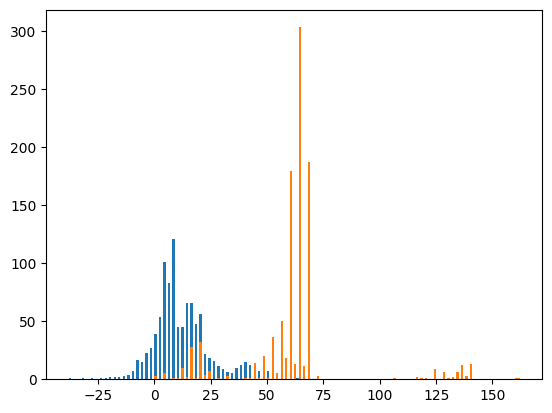

In [ ]:
vec_env2b2 = DummyVecEnv([lambda: make_env2b2(1)])
vec_env2b2.reset()
def do_random():
    done = False
    total_reward = 0
    k = 0
    while not done:
        k += 1
        # am = get_action_masks(env)
        action = [random.randint(0, 3)]
        _, reward, done, _ = vec_env2b2.step(action)
        if done: break
        total_reward += reward
    return total_reward
def do_thing():
    obs = vec_env2b2.reset()
    done = False
    total_reward = 0
    k = 0
    while not done:
        k += 1
        # am = get_action_masks(env)
        action, _ = model2b2.predict(obs, deterministic=False)
        obs, reward, done, _ = vec_env2b2.step(action)
        if done: break
        total_reward += reward
    return total_reward
def do_wfnc(fnc):
    l = np.array([fnc() for _ in range(1000)])
    plt.hist(l, bins=range(int(np.min(l)), int(np.max(l))+1, 1))
    thresh = 75
    a = b = 0
    for i in l:
        if i >= thresh:
            a += 1
        else:
            b += 1
    print(f"Threshold {thresh} -> {a} >=, {b} <, {np.mean(l[l>= thresh])} {np.std(l[l>= thresh])} >=, {np.mean(l[l < thresh])} {np.std(l[l < thresh])} <")
    print(np.mean(l), np.median(l), np.std(l), np.max(l), np.min(l))
    cnts = np.bincount(l.astype(int)[l>0])
    print(np.argmax(cnts))
do_wfnc(do_random)
do_wfnc(do_thing)

In [ ]:
# 4) play one game
obs = vec_env2b2.reset()
done = False
total_reward = 0
k = 0
dirr = {
    0 : "up",
    1 : "down",
    2 : "left",
    3 : "right",
}
vec_env2b2.render()
while not done:
    k += 1
    # am = get_action_masks(env)
    action, _ = model2b2.predict(obs, deterministic=True)
    obs, reward, done, _ = vec_env2b2.step(action)
    if done: break
    total_reward += reward
    print(f"Move {k}: {dirr[action[0]]}, reward: {reward}, total reward: {total_reward}")
    vec_env2b2.render()
    # print(action)
    time.sleep(1)
print("Final score (sum of merges):", total_reward)
vec_env2b2.render()


-------
|    2|
| 2   |
-------


Move 1: right, reward: [0.], total reward: [0.]
-------
| 2  2|
|    2|
-------


Move 2: right, reward: [4.], total reward: [4.]
-------
|    4|
| 2  2|
-------


Move 3: right, reward: [4.], total reward: [8.]
-------
|    4|
| 2  4|
-------


Move 4: up, reward: [8.], total reward: [16.]
-------
| 2  8|
|    2|
-------


Move 5: left, reward: [0.], total reward: [16.]
-------
| 2  8|
| 2  2|
-------


Move 6: right, reward: [4.], total reward: [20.]
-------
| 2  8|
| 2  4|
-------


Move 7: down, reward: [4.], total reward: [24.]
-------
| 2  8|
| 4  4|
-------


Move 8: right, reward: [8.], total reward: [32.]
-------
| 2  8|
| 2  8|
-------


Move 9: down, reward: [20.], total reward: [52.]
-------
|    2|
| 4 16|
-------


Move 10: left, reward: [0.], total reward: [52.]
-------
| 2  2|
| 4 16|
-------


Move 11: left, reward: [4.], total reward: [56.]
-------
| 4  2|
| 4 16|
-------


Move 12: down, reward: [8.], total reward: [64.]
-------
| 2 

In [ ]:
envv = DummyVecEnv([lambda *args: TwentyFortyEight2b2Env(render_mode='human')])
envv.envs[0].grid = np.array([[1, 2], [1, 3]], dtype=int)

In [ ]:
envv.envs[0]._move_and_merge(1)
envv.render()

AH [np.int64(2)]
AH [np.int64(3), np.int64(2)]
-------
|    4|
| 4  8|
-------




In [ ]:
vec_env2b2.envs[0]._move_and_merge()

True

# 4x4

In [38]:
class TwentyFortyEightEnv(gym.Env):
    metadata = {"render_modes": ["human"], "render_fps": 4}

    def __init__(self, render_mode='human'):
        super().__init__()
        self.render_mode = render_mode
        self.observation_space = spaces.Box(0, 17, shape=(4, 4), dtype=np.int8)
        self.action_space = spaces.Discrete(4)
        self.grid = None

    def reset(self, seed=None, options=None):
        # this lets gymnasium/SB3 seed properly
        super().reset(seed=seed)
        self.grid = np.zeros((4, 4), dtype=np.int8)
        self._add_tile()
        self._add_tile()
        return self.grid.copy(), {"action_mask": self.valid_action_mask()}

    def step(self, action):
        assert self.action_space.contains(action), f"{action} invalid"
        before = self.grid.copy()
        reward = self._move_and_merge(action)
        terminated = not self._can_move()
        if not np.array_equal(before, self.grid):
            self._add_tile()
        return self.grid.copy(), reward, terminated, False, {"action_mask": self.valid_action_mask()}

    def render(self):
        grd = (np.where(self.grid != 0, 2**self.grid.astype(np.int16), np.zeros_like(self.grid))).astype(int)
        f = lambda x: f"{x:>3}" if x != 0 else "   "
        print("-"*17)
        for r in grd:
            print("|", end="")
            print(*map(f, r), end="")
            print("|")
        print("-"*17)
        print("\n")

    def valid_action_mask(self):
        # True = valid, False = would do nothing
        mask = []
        for a in range(self.action_space.n):
            # simulate=True returns reward but *doesn’t* modify self.grid
            moved = self._move_and_merge(a, simulate=True) > 0
            mask.append(moved)
        return np.array(mask, dtype=bool)

    def _add_tile(self):
        empties = list(zip(*np.where(self.grid == 0)))
        if not empties: return
        y, x = random.choice(empties)
        self.grid[y, x] = 1 if random.random() < 0.9 else 2

    def _can_move(self):
        if np.any(self.grid == 0):
            return True
        for a in range(4):
            if self._move_and_merge(a, simulate=True) > 0:
                return True
        return False

    def _move_and_merge(self, action, simulate=False):
        grid = self.grid.copy() if simulate else self.grid
        orig = self.grid.copy()
        total_reward = 0
        for i in range(4):
            line = grid[:, i] if action < 2 else grid[i, :]
            if action % 2 == 1:
                line = line[::-1]
            nonzero = line[line > 0]
            merged, skip = [], False
            for j in range(len(nonzero)):
                if skip:
                    skip = False
                    continue
                if j+1 < len(nonzero) and nonzero[j] == nonzero[j+1]:
                    new_val = nonzero[j] + 1
                    merged.append(new_val)
                    total_reward += 2 ** new_val
                    skip = True
                else:
                    merged.append(nonzero[j])
            merged = np.array(merged + [0]*(4-len(merged)), dtype=np.int8)
            if action % 2 == 1:
                merged = merged[::-1]
            if action < 2:
                grid[:, i] = merged
            else:
                grid[i, :] = merged
        # add in something to really incentivize not doing nothing
        if (grid == orig).all():
            total_reward = -2.0
        if not simulate:
            self.grid = grid
        return total_reward

In [ ]:
# # 1) sanity-check env
# base_env = TwentyFortyEightEnv()
# check_env(base_env, warn=True)                # <-- will raise if your env is non-compliant

# def make_env():
#     env = TwentyFortyEightEnv(render_mode='human')
#     return ActionMasker(env, lambda e: e.valid_action_mask())

# class MaskableDummyVecEnv(DummyVecEnv):
#     def has_attr(self, name: str) -> bool:
#         # MaskablePPO will call `env.has_attr("action_masks")`
#         return all(hasattr(env, name) for env in self.envs)
#     def action_masks(self) -> np.ndarray:
#         # must return shape (n_envs, n_actions)
#         masks = [env.action_masks() for env in self.envs]
#         return np.stack(masks, axis=0)

# # 2) vectorize
# vec_env = MaskableDummyVecEnv([make_env])


# # 3) train with any SB3 algo
# model = MaskablePPO("MlpPolicy", vec_env, verbose=1, n_epochs=30, learning_rate=5e-3)
# # 500_000 with default lr gives a score 300 smth
# model.learn(total_timesteps=100_000)


In [109]:

import torch.nn as nn

from stable_baselines3 import PPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor


class CustomCNN(BaseFeaturesExtractor):
    """
    :param observation_space: (gym.Space)
    :param features_dim: (int) Number of features extracted.
        This corresponds to the number of unit for the last layer.
    """

    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 160):
        super(CustomCNN, self).__init__(observation_space, features_dim)
        # We assume CxHxW images (channels first)
        # Re-ordering will be done by pre-preprocessing or wrapper
        n_input_channels =10
        self.embed= nn.Embedding(20,10)
        self.posEm= nn.Embedding(16,10)
        self.cnn = nn.Sequential(
    
            nn.Conv2d(n_input_channels, 10, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.Conv2d(10, 10, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.Conv2d(10, 10, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.Conv2d(10, 10, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.Conv2d(10, 10, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.Flatten(start_dim=1),
        )

        # Compute shape by doing one forward pass
        with torch.no_grad():
            n_flatten = 10*16
            
        self.linear = nn.Sequential(
            nn.Linear(n_flatten, features_dim//2), nn.ReLU(),
            nn.Linear(features_dim//2, features_dim//2), nn.ReLU(),
            nn.Linear(features_dim//2, features_dim//4), nn.ReLU())
        
    def do_embed(self, observations):
        add_pos=self.posEm(torch.tensor([i for i in range(16)], dtype=int)).reshape((4,4,10))
        obs=torch.tensor(observations, dtype=int)
        return(self.embed(obs)+add_pos).reshape((observations.shape[0],10,4,4))


    def forward(self, observations) -> torch.Tensor:
        embed= self.do_embed(observations)
        final1=self.linear(self.cnn(embed))
        final2= self.linear(self.cnn( torch.rot90( embed,1,[2,3])))
        final3= self.linear(self.cnn( torch.rot90( embed,2,[2,3])))
        final4= self.linear(self.cnn( torch.rot90( embed,3,[2,3])))

        # print(torch.concat( (final1,final2,final3,final4)).shape,"Hi",final1.shape)
        return torch.concat( (final1,final2,final3,final4),dim=1)
    
class WideMLPExtractor(BaseFeaturesExtractor):
    """
    A FeaturesExtractor that flattens the observation and passes it through
    two wide linear layers of width `features_dim`, returning a `features_dim`-length feature vector.
    """
    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 2000):
        super().__init__(observation_space, features_dim)
        n_input = int(np.prod(observation_space.shape))
        width = features_dim
        
        self.net = nn.Sequential(
            nn.Flatten(),             # (batch_size, n_input)
            nn.Linear(n_input, width),# → (batch_size, features_dim)
            nn.ReLU(),
            nn.Linear(width, width),  # → (batch_size, features_dim)
            nn.ReLU(),
            nn.Linear(width, width),  # → (batch_size, features_dim)
            nn.ReLU(),
            nn.Linear(width, width),  # → (batch_size, features_dim)
            nn.ReLU(),
            nn.Linear(width, width),  # → (batch_size, features_dim)
            nn.ReLU(),
            nn.Linear(width, width),  # → (batch_size, features_dim)
            nn.ReLU()
        )

    def forward(self, observations):
        """
        :param observations: Tensor of shape (batch_size, *obs_shape)
        :return: Tensor of shape (batch_size, features_dim)
        """
        return self.net(observations)

# policy_kwargs = dict(
#     features_extractor_class=CustomCNN,
#     features_extractor_kwargs=dict(features_dim=32),
#     net_arch=dict(pi=[16], vf=[16])
# )

policy_kwargs = dict(
    features_extractor_class=WideMLPExtractor,
    features_extractor_kwargs=dict(features_dim=1024),
)
# 1) sanity-check env
base_env = TwentyFortyEightEnv()
check_env(base_env, warn=True)                # <-- will raise if your env is non-compliant

def make_env():
    env = TwentyFortyEightEnv(render_mode='human')
    return env

# 2) vectorize
vec_env = DummyVecEnv([make_env]*8)


# 3) train with any SB3 algo
# model = PPO("MlpLstmPolicy", vec_env, verbose=1, n_epochs=30, learning_rate=5e-3)
# 500_000 with default lr gives a score 300 smth
# model.learn(total_timesteps=200_000)


model = PPO("MlpPolicy", vec_env, policy_kwargs=policy_kwargs, verbose=1, n_steps=100)
model.learn(500000)

/Users/aayanarish/Library/Python/3.10/lib/python/site-packages/stable_baselines3/common/env_checker.py:272: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(
/Users/aayanarish/Library/Python/3.10/lib/python/site-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 800`, after every 12 untruncated mini-batches, there will be a truncated mini-batch of size 32
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=100 and n_envs=8)
  warnings.warn(


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 2032 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 800  |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 1600        |
| train/                  |             |
|    approx_kl            | 0.006412781 |
|    clip_fraction        | 0.0522      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance   | 0.000308    |
|    learning_rate        | 0.0003      |
|    loss                 | 4.47e+03    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00486    |
|    value_loss           | 8.86e+03    |
-----------------------------------------
-----------------

/var/folders/d0/dk6cszhs0x5d2_p1gnjcc9r40000gn/T/ipykernel_85620/602414542.py:79: RuntimeWarning: overflow encountered in scalar add
  total_reward += 2 ** new_val


-----------------------------------------
| time/                   |             |
|    fps                  | 456         |
|    iterations           | 103         |
|    time_elapsed         | 180         |
|    total_timesteps      | 82400       |
| train/                  |             |
|    approx_kl            | 0.010670891 |
|    clip_fraction        | 0.106       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.21       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 2.24e+03    |
|    n_updates            | 1020        |
|    policy_gradient_loss | 0.00188     |
|    value_loss           | 5.97e+03    |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 456         |
|    iterations           | 104         |
|    time_elapsed         | 182         |
|    total_timesteps      | 83200 

In [ ]:
# # 1) sanity-check env
# base_env = TwentyFortyEightEnv()
# check_env(base_env, warn=True)                # <-- will raise if your env is non-compliant

# def make_env():
#     env = TwentyFortyEightEnv(render_mode='human')
#     return env
# # def make_env_play():
# #     env = TwentyFortyEightEnv_play(render_mode='human')
# #     return env
# # 2) vectorize
# # vec_env = DummyVecEnv([make_env])

# # vec_env_play = DummyVecEnv([make_env_play])

/Users/thomasdellavigna/Library/Python/3.9/lib/python/site-packages/stable_baselines3/common/env_checker.py:272: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


In [43]:
# #rtain
# model = PPO("MlpLstmPolicy", vec_env, verbose=1, n_epochs=30, learning_rate=5e-3)
# # 500_000 with default lr gives a score 300 smth
# model.learn(total_timesteps=200_000)

In [45]:
# 4) play one game
obs = vec_env.reset()
done = False
total_reward = 0
k = 0
dirr = {
    0 : "up",
    1 : "down",
    2 : "left",
    3 : "right",
}
env = make_env()
# vec_env_play = make_env_play()
re=nn.ReLU()
while not done:
    k += 1
    # am = get_action_masks(env)
    action, _ = model.predict(obs, deterministic=False)
    obs, reward, done, _ = vec_env.step(action)
    reward=max(int(reward[0]),0)
    total_reward += reward
    print(f"Move {k}: {dirr[action[0]]}, reward: {reward}, total reward: {total_reward}")
    vec_env.render()
    # print(action)
    time.sleep(0.2)
print("Final score (sum of merges):", total_reward)

Move 1: up, reward: 0, total reward: 0
-----------------
|  2   2        |
|               |
|               |
|      4        |
-----------------


Move 2: right, reward: 4, total reward: 4
-----------------
|              4|
|               |
|      2        |
|              4|
-----------------


Move 3: down, reward: 8, total reward: 12
-----------------
|               |
|               |
|  2            |
|      2       8|
-----------------


Move 4: up, reward: 0, total reward: 12
-----------------
|  2   2       8|
|      2        |
|               |
|               |
-----------------


Move 5: right, reward: 4, total reward: 16
-----------------
|          4   8|
|      2       2|
|               |
|               |
-----------------


Move 6: down, reward: 0, total reward: 16
-----------------
|  2            |
|               |
|              8|
|      2   4   2|
-----------------


Move 7: up, reward: 0, total reward: 16
-----------------
|  2   2   4   8|
|              2

KeyboardInterrupt: 

810.8 800.0 323.7656 1492.0 180.0


/var/folders/d0/dk6cszhs0x5d2_p1gnjcc9r40000gn/T/ipykernel_85620/602414542.py:79: RuntimeWarning: overflow encountered in scalar add
  total_reward += 2 ** new_val


946.1 874.0 423.58093 2120.0 244.0


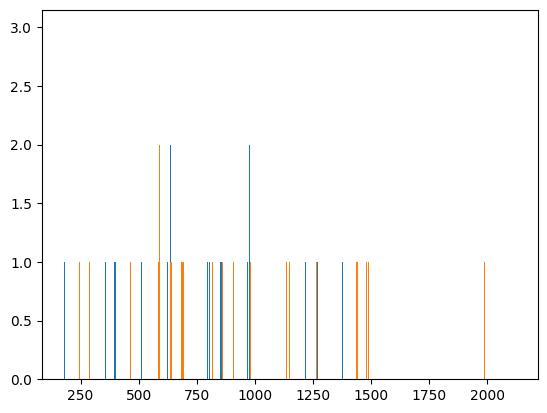

In [110]:
def do_random():
    vec_env = DummyVecEnv([make_env])
    obs = vec_env.reset()
    done = False
    total_reward = 0
    k = 0
    while not done:
        k += 1
        # am = get_action_masks(env)
        action = [random.randint(0, 3)]
        _, reward, done, _ = vec_env.step(action)
        total_reward += max(reward[0],0)
    return total_reward
def do_thing():
    vec_env = DummyVecEnv([make_env])
    obs = vec_env.reset()
    done = False
    total_reward = 0
    k = 0
    while not done:
        k += 1
        # am = get_action_masks(env)
        action, _ = model.predict(obs, deterministic=False)
        obs, reward, done, _ = vec_env.step(action)
        total_reward += max(reward[0],0)
    return total_reward
def do_wfnc(fnc):
    l = np.array([fnc() for _ in range(40)])
    plt.hist(l, bins=range(int(np.min(l)), int(np.max(l))+1, 2))
    print(np.mean(l), np.median(l), np.std(l), np.max(l), np.min(l))
do_wfnc(do_random)
do_wfnc(do_thing)

942.12 860.0 367.69052 1992.0 320.0
1011.6 964.0 441.0411 2572.0 196.0


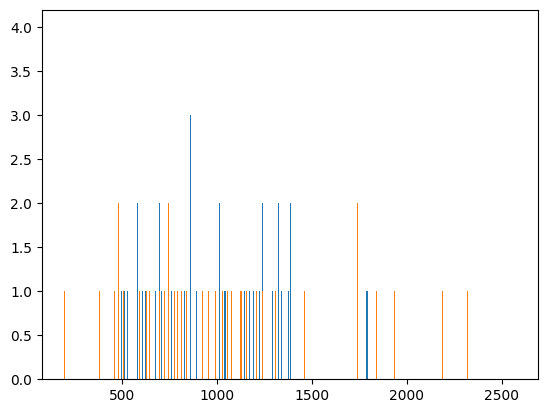

In [111]:
def do_random():
    vec_env = DummyVecEnv([make_env])
    obs = vec_env.reset()
    done = False
    total_reward = 0
    k = 0
    while not done:
        k += 1
        # am = get_action_masks(env)
        action = [random.randint(0, 3)]
        _, reward, done, _ = vec_env.step(action)
        total_reward += max(reward[0],0)
    return total_reward
def do_thing():
    vec_env = DummyVecEnv([make_env])
    obs = vec_env.reset()
    done = False
    total_reward = 0
    k = 0
    while not done:
        k += 1
        # am = get_action_masks(env)
        action, _ = model.predict(obs, deterministic=False)
        obs, reward, done, _ = vec_env.step(action)
        total_reward += max(reward[0],0)
    return total_reward
def do_wfnc(fnc):
    l = np.array([fnc() for _ in range(100)])
    plt.hist(l, bins=range(int(np.min(l)), int(np.max(l))+1, 2))
    print(np.mean(l), np.median(l), np.std(l), np.max(l), np.min(l))
do_wfnc(do_random)
do_wfnc(do_thing)